## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_data_cancer.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/Cancer/cancer.pt"
Data = torch.load(path)
Data

{'x': tensor([[1.7990e+01, 1.0380e+01, 1.2280e+02,  ..., 2.6540e-01, 4.6010e-01,
          1.1890e-01],
         [2.0570e+01, 1.7770e+01, 1.3290e+02,  ..., 1.8600e-01, 2.7500e-01,
          8.9020e-02],
         [1.9690e+01, 2.1250e+01, 1.3000e+02,  ..., 2.4300e-01, 3.6130e-01,
          8.7580e-02],
         ...,
         [1.3030e+01, 1.8420e+01, 8.2610e+01,  ..., 5.0130e-02, 1.9870e-01,
          6.1690e-02],
         [1.3080e+01, 1.5710e+01, 8.5630e+01,  ..., 7.2830e-02, 3.1840e-01,
          8.1830e-02],
         [9.5040e+00, 1.2440e+01, 6.0340e+01,  ..., 6.2270e-02, 2.4500e-01,
          7.7730e-02]]), 'edge_index': tensor([[ 0,  0,  0,  ..., 79, 79, 79],
         [ 2,  3,  4,  ..., 72, 74, 76]]), 'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]), 'train

In [ ]:
path = F"/gdrive/MyDrive/Cancer/p_links_cancer.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([80, 80])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 8.0 MB/s 
     |████████████████████████████████| 4.6 MB 8.4 MB/s 
     |████████████████████████████████| 280 kB 8.7 MB/s 


# Create BGAT and GAT layers. 

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GATConv

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [ ]:
class Myconv_BGAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 30, out_channels = 15)
        self.conv2 =  BGATConv(15, 2)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.log_softmax(h)
        return h
        
model_BGAT = Myconv_BGAT()
print(model_BGAT)
print(model_BGAT.forward(Data["x"], Data["edge_index"]))

Myconv_BGAT(
  (conv1): BGATConv(30, 15)
  (conv2): BGATConv(15, 2)
)
tensor([[-5.8928e+00, -2.7629e-03],
        [-6.2349e+00, -1.9617e-03],
        [-5.5977e+00, -3.7133e-03],
        [-5.5730e+00, -3.8061e-03],
        [-3.9700e+00, -1.9054e-02],
        [-4.8565e+00, -7.8078e-03],
        [-6.3340e+00, -1.7764e-03],
        [-6.5407e+00, -1.4446e-03],
        [-5.6902e+00, -3.3845e-03],
        [-5.2904e+00, -5.0525e-03],
        [-6.6747e+00, -1.2633e-03],
        [-6.8860e+00, -1.0225e-03],
        [-4.6494e+00, -9.6129e-03],
        [-4.3784e+00, -1.2625e-02],
        [-6.3528e+00, -1.7433e-03],
        [-6.0144e+00, -2.4463e-03],
        [-5.7492e+00, -3.1905e-03],
        [-5.3906e+00, -4.5698e-03],
        [-2.9897e+00, -5.1612e-02],
        [-7.3064e+00, -6.7152e-04],
        [-7.0723e+00, -8.4865e-04],
        [-5.3999e+00, -4.5273e-03],
        [-6.2035e+00, -2.0243e-03],
        [-6.8066e+00, -1.1071e-03],
        [-6.6792e+00, -1.2576e-03],
        [-7.2586e+00, -7.0428e

<ipython-input-8-b75922bbf427>:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


In [ ]:
class Myconv_GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels = 30, out_channels = 30)
        self.conv2 =  GATConv(30, 10)
        self.conv3 =  GATConv(10, 2)
        

    def forward(self, x, edge_index):
        f = self.conv1(x, edge_index)
        f = F.torch.tanh(f)
        f = self.conv2(f, edge_index)
        f = F.torch.tanh(f)
        f = self.conv3(f, edge_index)# Final GNN embedding space.
        f = F.torch.tanh(f)
        return f
        

model_GAT = Myconv_GAT()
print(model_GAT)
print(model_GAT.forward(Data["x"], Data["edge_index"]))

Myconv_GAT(
  (conv1): GATConv(30, 30, heads=1)
  (conv2): GATConv(30, 10, heads=1)
  (conv3): GATConv(10, 2, heads=1)
)
tensor([[ 0.9850, -0.3719],
        [ 0.9852, -0.3369],
        [ 0.9836, -0.3399],
        [ 0.9850, -0.3725],
        [ 0.9855, -0.3528],
        [ 0.9839, -0.3196],
        [ 0.9857, -0.3511],
        [ 0.9849, -0.3387],
        [ 0.9852, -0.3534],
        [ 0.9844, -0.3152],
        [ 0.9848, -0.3064],
        [ 0.9853, -0.3682],
        [ 0.9842, -0.2949],
        [ 0.9850, -0.3705],
        [ 0.9853, -0.3580],
        [ 0.9846, -0.3157],
        [ 0.9843, -0.3241],
        [ 0.9846, -0.3457],
        [ 0.9848, -0.3468],
        [ 0.9848, -0.3366],
        [ 0.9853, -0.3621],
        [ 0.9854, -0.3462],
        [ 0.9852, -0.3531],
        [ 0.9845, -0.3353],
        [ 0.9849, -0.3458],
        [ 0.9851, -0.3621],
        [ 0.9829, -0.2771],
        [ 0.9860, -0.3540],
        [ 0.9849, -0.3438],
        [ 0.9857, -0.3436],
        [ 0.9843, -0.3232],
        [ 0

# Train BGAT and GAT models. 

In [ ]:
model = Myconv_BGAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_BGAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_BGAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_BGAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_BGAT

train_loss_BGAT_ = []
for epoch in range(1, 201):
  epoch_train_lossBGAT = []
  train_loss_BGAT = train_BGAT(Data)
  epoch_train_lossBGAT.append(train_loss_BGAT.item())
  train_loss_BGAT_.append(sum(epoch_train_lossBGAT)/len(epoch_train_lossBGAT))
  print(f'Train_BGAT:  {train_loss_BGAT:.3f}') 

Train_BGAT:  3.015
Train_BGAT:  1.955
Train_BGAT:  1.004
Train_BGAT:  0.650
Train_BGAT:  0.660
Train_BGAT:  0.701
Train_BGAT:  0.699
Train_BGAT:  0.747
Train_BGAT:  0.736
Train_BGAT:  0.705
Train_BGAT:  0.697
Train_BGAT:  0.686
Train_BGAT:  0.664
Train_BGAT:  0.648
Train_BGAT:  0.641
Train_BGAT:  0.639
Train_BGAT:  0.637


<ipython-input-8-b75922bbf427>:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


Train_BGAT:  0.640
Train_BGAT:  0.640
Train_BGAT:  0.636
Train_BGAT:  0.624
Train_BGAT:  0.620
Train_BGAT:  0.620
Train_BGAT:  0.619
Train_BGAT:  0.616
Train_BGAT:  0.607
Train_BGAT:  0.603
Train_BGAT:  0.601
Train_BGAT:  0.599
Train_BGAT:  0.600
Train_BGAT:  0.600
Train_BGAT:  0.600
Train_BGAT:  0.600
Train_BGAT:  0.599
Train_BGAT:  0.598
Train_BGAT:  0.596
Train_BGAT:  0.596
Train_BGAT:  0.595
Train_BGAT:  0.594
Train_BGAT:  0.593
Train_BGAT:  0.592
Train_BGAT:  0.590
Train_BGAT:  0.589
Train_BGAT:  0.588
Train_BGAT:  0.586
Train_BGAT:  0.585
Train_BGAT:  0.584
Train_BGAT:  0.583
Train_BGAT:  0.582
Train_BGAT:  0.581
Train_BGAT:  0.580
Train_BGAT:  0.579
Train_BGAT:  0.577
Train_BGAT:  0.574
Train_BGAT:  0.572
Train_BGAT:  0.571
Train_BGAT:  0.570
Train_BGAT:  0.569
Train_BGAT:  0.569
Train_BGAT:  0.568
Train_BGAT:  0.568
Train_BGAT:  0.567
Train_BGAT:  0.565
Train_BGAT:  0.564
Train_BGAT:  0.563
Train_BGAT:  0.562
Train_BGAT:  0.561
Train_BGAT:  0.560
Train_BGAT:  0.559
Train_BGAT: 

In [ ]:
model = Myconv_GAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005, weight_decay = 5e-4)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_GAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_GAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_GAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_GAT

train_loss_GAT_ = []
for epoch in range(1, 201):
  epoch_train_lossGAT = []
  train_loss_GAT = train_GAT(Data)
  epoch_train_lossGAT.append(train_loss_GAT.item())
  train_loss_GAT_.append(sum(epoch_train_lossGAT)/len(epoch_train_lossGAT))
  print(f'Train_GAT:  {train_loss_GAT:.3f}') 

Train_GAT:  0.894
Train_GAT:  0.883
Train_GAT:  0.874
Train_GAT:  0.863
Train_GAT:  0.850
Train_GAT:  0.835
Train_GAT:  0.823
Train_GAT:  0.813
Train_GAT:  0.802
Train_GAT:  0.789
Train_GAT:  0.776
Train_GAT:  0.769
Train_GAT:  0.762
Train_GAT:  0.754
Train_GAT:  0.747
Train_GAT:  0.741
Train_GAT:  0.736
Train_GAT:  0.730
Train_GAT:  0.724
Train_GAT:  0.719
Train_GAT:  0.715
Train_GAT:  0.711
Train_GAT:  0.708
Train_GAT:  0.706
Train_GAT:  0.703
Train_GAT:  0.702
Train_GAT:  0.700
Train_GAT:  0.698
Train_GAT:  0.697
Train_GAT:  0.696
Train_GAT:  0.694
Train_GAT:  0.693
Train_GAT:  0.692
Train_GAT:  0.692
Train_GAT:  0.691
Train_GAT:  0.690
Train_GAT:  0.689
Train_GAT:  0.688
Train_GAT:  0.687
Train_GAT:  0.687
Train_GAT:  0.686
Train_GAT:  0.686
Train_GAT:  0.686
Train_GAT:  0.685
Train_GAT:  0.685
Train_GAT:  0.685
Train_GAT:  0.685
Train_GAT:  0.684
Train_GAT:  0.684
Train_GAT:  0.684
Train_GAT:  0.684
Train_GAT:  0.684
Train_GAT:  0.684
Train_GAT:  0.684
Train_GAT:  0.683
Train_GAT:

# Visualize train_loss for both models. 

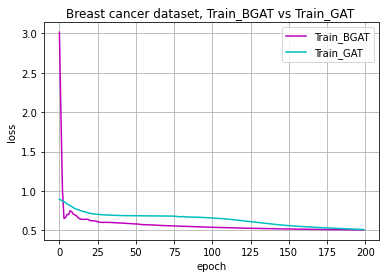

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_BGAT_, "m")
plt.plot(train_loss_GAT_, "c")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train_BGAT','Train_GAT'])
plt.title('Breast cancer dataset, Train_BGAT vs Train_GAT ')
plt.grid()
plt.show()